In [6]:
import re
import numpy as np
from numpy import array
import csv
import random
import pandas as pd
import re
from urllib.parse import unquote

data = pd.read_csv('emcl_extract.csv')
X = data[['method','uri','query','protocol','host','connection','accept',
'accept_charset','accept_language','cache_control','cookie','pragma','user_agent','content_length','content_type']]
y = data['label']

X_string = []
cols = X.columns
for i in range(len(X)):
    temp = ''
    for col in cols:
        temp += " " + str(X.iloc[i][col])
    ans = ''
    for t in temp:
        ans += t
    
    ans =  unquote(ans)
    
    ans = ans.lower()
    
    special_chars = ['/','&','=','+', ';', ',']
    for char in special_chars:
      ans = ans.replace(char, ' ')
    
    ans = ' '.join(ans.split())

    X_string.append(ans)
    

In [7]:
print(X_string[154])

get iq eqs td8tosvr8djcrkqt ekadj4jjfritmohrb svqyp2lw3x.tiff v5o4 <meta http-equiv "refresh " content " 0 url javascript: [alert ('rhhla') ] " > oo4s ortktohg3wntrtnnnc http 1.0 118.212.134.121 keep-alive * * q 0.8 x-mac-japanese q 0.4 x-mac-greek x-mac-hebrew x-mac-ce egbue-tui2ai q 0.2 i-a tesoyamm-ied q 0.5 wqs-hzrdan q 0.5 min-fresh 83735 hd 2093 ghnp2d 'dau' s2ztik http: www.2v9ns1on.cz nan nan


In [8]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences


tokenizer = Tokenizer(filters = '', num_words = 3000)
tokenizer.fit_on_texts(X_string)


sequences = tokenizer.texts_to_sequences(X_string)
pad = pad_sequences(sequences,padding='post')

print(len(pad))
print(len(pad[1]))
print(pad[0])

50116
65
[   5 1022  759  374    4    7   14    2    2    2    2   31   97   74
    6   33    3    3    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0]


In [9]:
import random
import numpy as np

def da_sana_algorithm(dataset, sequences, f):

    au_dataset = []
    L = [len(req) for req in dataset]
    L_min = min(L)
    L_max = max(L)
    mean = (f + 2*f) / 2
    stddev = (2*f - f) / 4

    for request, Si  in zip(dataset, sequences ):

        length = len(request)
        L_normalized = (length - L_min) / (L_max - L_min)


        Ci = np.random.binomial(1, L_normalized*0.05 ,len(Si))

        Ni_Gauss = np.random.normal(mean, stddev, len(Si))
        Ni = abs(Ni_Gauss).astype(int)
        

        au_dataset.append(np.array(Si)*(Ci^1) + Ni*Ci)


    return au_dataset

In [10]:

au_seq = np.array([*pad, *da_sana_algorithm(X_string,pad,3000)])
lable = np.array([*y,*y]).astype(np.int32)

print(au_seq.shape)
print(lable.shape)
print(type(lable[0]))

print(au_seq[3])

(100232, 65)
(100232,)
<class 'numpy.int32'>
[  5 370 172 263 815 975  71   4   8  13  10 162  25  93  28   2 145   1
  18 143   1  22 124  31  60   6   9  17  34  11  45  42  41 213  12   3
   3   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0]


In [11]:
labels={'Valid':0, 'XSS':1, 'SqlInjection':2, 'LdapInjection':3,
        'XPathInjection':4, 'PathTransversal':5, 'OsCommanding':6, 'SSI':7}

In [12]:
from keras import models
from keras import layers
from keras.layers import Embedding, Dense, Dropout, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from sklearn.metrics import accuracy_score

# split the data into training, validation, and testing sets
train_X, test_X, train_y, test_y = train_test_split(au_seq, lable, test_size=0.2, random_state=42)
train_X, val_X, train_y, val_y = train_test_split(train_X, train_y, test_size=0.25, random_state=42)

# size of the vector space in which characters will be embedded
embedding_dim = 32
max_chars = 10000

def build_model():
    model = Sequential()
    model.add(Embedding(max_chars, embedding_dim, input_length=train_X.shape[1]))
    model.add(Bidirectional(LSTM(units=128, activation='tanh', dropout=0.5, recurrent_dropout=0.5, return_sequences=True)))
    model.add(Bidirectional(LSTM(units=128, activation='tanh', dropout=0.5, recurrent_dropout=0.5)))
    model.add(Dense(8, activation='softmax'))
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

model = build_model()
print(model.summary())

model.fit(train_X, train_y, epochs=10, batch_size=128, validation_data=(val_X, val_y))

test_loss, test_acc = model.evaluate(test_X, test_y)
print("Test Accuracy:", test_acc)

# Predicting labels for test data
y_pred = np.argmax(model.predict(test_X), axis=-1)

# Calculating accuracy for each label
accuracy_per_label = {}
for label in labels:
    indices = np.where(test_y == labels[label])
    accuracy_per_label[label] = accuracy_score(test_y[indices], y_pred[indices])

print("Accuracy per Label:", accuracy_per_label)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 65, 32)            320000    
                                                                 
 bidirectional (Bidirectiona  (None, 65, 256)          164864    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 256)              394240    
 nal)                                                            
                                                                 
 dense (Dense)               (None, 8)                 2056      
                                                                 
Total params: 881,160
Trainable params: 881,160
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
470/470 [=========================

                 precision    recall  f1-score   support

          Valid       0.95      1.00      0.97     13946
            XSS       0.99      0.84      0.91       719
   SqlInjection       0.97      0.83      0.89       885
  LdapInjection       0.99      0.89      0.93       947
 XPathInjection       0.99      0.88      0.93       914
PathTransversal       0.94      0.79      0.86       959
   OsCommanding       0.96      0.91      0.93       948
            SSI       0.96      0.89      0.92       729

       accuracy                           0.95     20047
      macro avg       0.97      0.88      0.92     20047
   weighted avg       0.96      0.95      0.95     20047



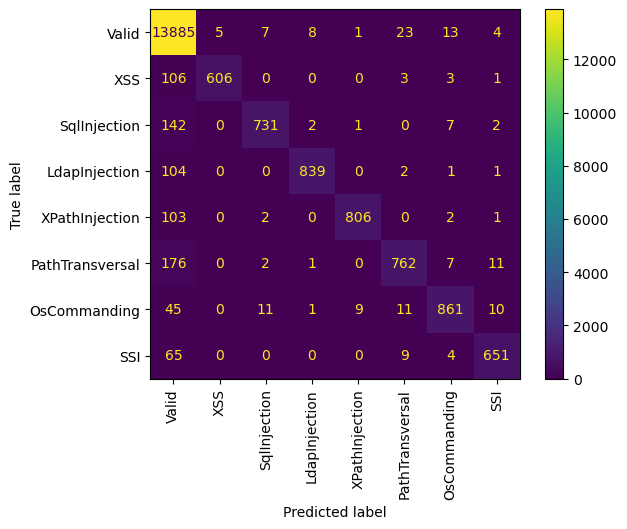

In [20]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

print(classification_report(test_y, y_pred, target_names=labels))

ConfusionMatrixDisplay.from_predictions(test_y, y_pred, display_labels= labels, xticks_rotation = 'vertical')
